In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from MotionDataset import MotionData
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

cuda


In [19]:
class MotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.0):
        super(MotionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [20]:
train_labels = "./data/labels/train.csv"
val_labels = "./data/labels/val.csv"
val_dir = train_dir = "./data/"

train_dataset = MotionData(train_labels, train_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = MotionData(val_labels, val_dir)
val_loader = DataLoader(val_dataset, batch_size=16)

In [21]:
def train(num_epochs, model, criterion, optim):
    losses = []
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for x in range(num_epochs):
        model.train()
        running_loss = 0
        train_correct = train_total = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            yhat = model(X.permute(0,2,1))
            _, pred = torch.max(nn.functional.softmax(yhat.data, dim=1), 1)
            train_total += y.size(0)
            loss = criterion(yhat, y)
            running_loss += loss.item()
            train_correct += (pred == y).sum().item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        losses.append(running_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            val_correct = val_total = 0
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                yhat = model(X.permute(0,2,1))
                _, pred = torch.max(nn.functional.softmax(yhat.data, dim=1), 1)
                val_total += y.size(0)
                val_loss = criterion(yhat, y)
                val_correct += (pred == y).sum().item()
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss.item())
        print(f"Epoch {x+1}, train loss: {train_loss:.4}, train acc: {train_acc:.3%}, val loss: {val_loss.item():.4}, val acc: {val_acc:.3%}")

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim((0, 1.5))
    plt.legend()
    plt.show()

    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Hidden Size: 512, #Layers: 3
Epoch 1, train loss: 1.398, train acc: 24.242%, val loss: 1.36, val acc: 48.000%
Epoch 2, train loss: 1.387, train acc: 29.293%, val loss: 1.487, val acc: 14.000%
Epoch 3, train loss: 1.358, train acc: 32.323%, val loss: 2.081, val acc: 14.000%
Epoch 4, train loss: 1.345, train acc: 33.838%, val loss: 1.959, val acc: 30.000%
Epoch 5, train loss: 1.299, train acc: 38.384%, val loss: 1.185, val acc: 32.000%
Epoch 6, train loss: 1.244, train acc: 39.394%, val loss: 1.444, val acc: 32.000%
Epoch 7, train loss: 1.139, train acc: 41.414%, val loss: 1.4, val acc: 36.000%
Epoch 8, train loss: 1.222, train acc: 45.455%, val loss: 2.471, val acc: 32.000%
Epoch 9, train loss: 1.15, train acc: 43.939%, val loss: 1.362, val acc: 56.000%
Epoch 10, train loss: 1.175, train acc: 48.990%, val loss: 1.582, val acc: 52.000%
Epoch 11, train loss: 0.9518, train acc: 62.626%, val loss: 1.914, val acc: 62.000%
Epoch 12, train loss: 0.9345, train acc: 64.646%, val loss: 1.567, val

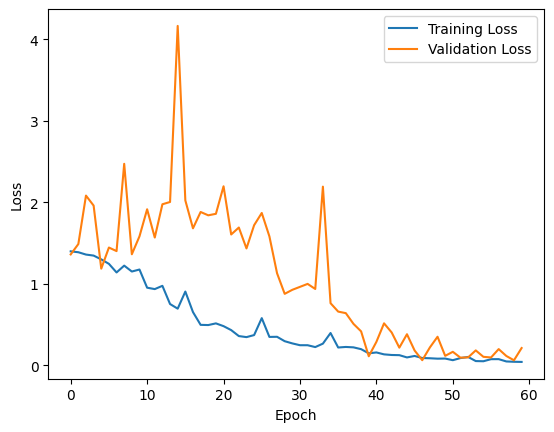

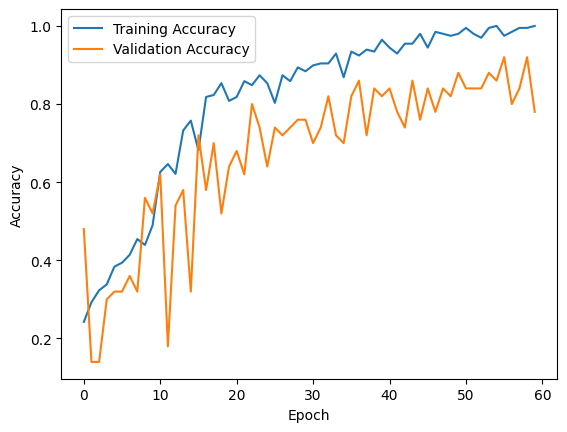

Hidden Size: 720, #Layers: 3
Epoch 1, train loss: 1.392, train acc: 27.778%, val loss: 1.238, val acc: 32.000%
Epoch 2, train loss: 1.376, train acc: 25.253%, val loss: 0.9301, val acc: 32.000%
Epoch 3, train loss: 1.356, train acc: 29.798%, val loss: 2.594, val acc: 14.000%
Epoch 4, train loss: 1.365, train acc: 37.374%, val loss: 1.092, val acc: 34.000%
Epoch 5, train loss: 1.295, train acc: 42.424%, val loss: 1.24, val acc: 36.000%
Epoch 6, train loss: 1.166, train acc: 43.939%, val loss: 0.2142, val acc: 32.000%
Epoch 7, train loss: 1.515, train acc: 50.505%, val loss: 2.058, val acc: 42.000%
Epoch 8, train loss: 1.108, train acc: 51.010%, val loss: 1.739, val acc: 50.000%
Epoch 9, train loss: 1.045, train acc: 50.505%, val loss: 0.817, val acc: 40.000%
Epoch 10, train loss: 1.1, train acc: 53.030%, val loss: 1.587, val acc: 58.000%
Epoch 11, train loss: 0.9715, train acc: 63.636%, val loss: 1.453, val acc: 62.000%
Epoch 12, train loss: 0.7882, train acc: 70.707%, val loss: 2.555, 

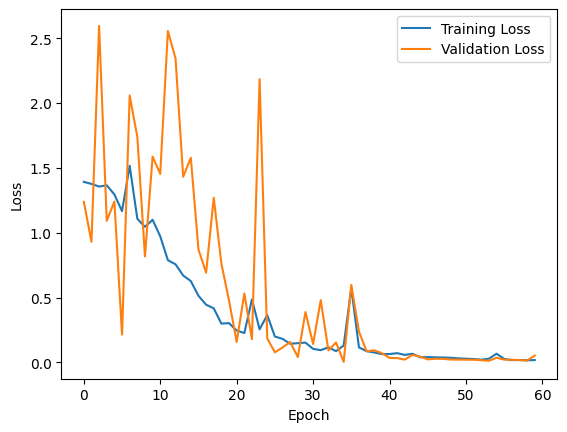

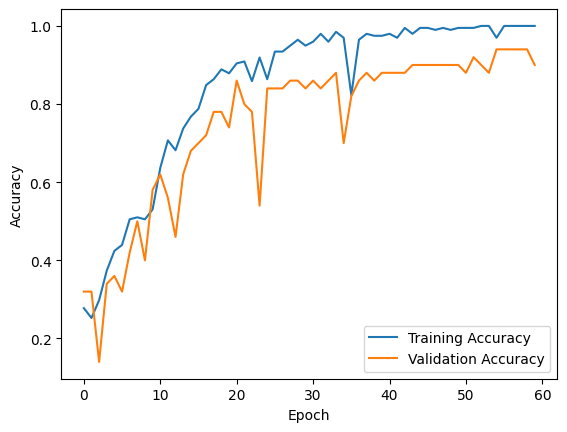

In [22]:
# model parameters
input_size = 6
# classifying up:0, down:1, left:2, right:3
num_classes = 4
num_epochs = 60
criterion = nn.CrossEntropyLoss()
layers = [3]
sizes = [512, 720]
for layer in layers:# 3, 512
    for hid_size in sizes:
        print(f"Hidden Size: {hid_size}, #Layers: {layer}")
        model = MotionLSTM(500, hid_size, layer, num_classes).to(device)
        optim = torch.optim.Adagrad(model.parameters(), lr=1e-3)
        train(num_epochs, model, criterion, optim)